# Stress-Testing Experiments Evaluation | Across Many Models

In this notebook we conduct targeted stress-testings experiments using the knowledge abstractions we create over augmented images. These stress-tests include:

- Over-all Performance
- Performance over Data Distributions (Native Benchmarks)
- Performance over Augmentation size
- Performance over Semantic Change 
- Performance over entity groups 
- Over many change computations created by exitsing research
- Over semantic change pairs (inpainting)
    - For example (car --> concrete)

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import ipdb
from PIL import Image
import pdb

import warnings
warnings.filterwarnings('ignore')

### Data Paths & Data Loading

In [2]:
PRED_ROOT = "/home/jkruk3/how_fake/How-Fake-is-Too-Fake/detectors/preds"
DATA_ROOT = "/data/jkruk3/half-truths/data_samples/eval_sample_5p/full"
model_pred_paths = {
    "DinoV2" : "dinov2_preds.csv",
    "CNNSpot" : "cnnspot_preds.csv",
    "DIRE" : "dire_preds.csv",
    "UniversalFakeDetect" : "universalfakedetect_preds.csv",
    "CrossEfficientNet" : "crossefficient_labels_and_preds.csv",
    "De-Fake" : "defake_preds.csv"
}
accept_models = ["UniversalFakeDetect", "CrossEfficientNet", "De-Fake"]

METRICS_DIR = "/home/jkruk3/how_fake/How-Fake-is-Too-Fake/detectors/preds/metrics"
if not os.path.exists(METRICS_DIR):
    os.mkdir(METRICS_DIR)
    
model_preds = {}
for model, pth in model_pred_paths.items():
    data = pd.read_csv(os.path.join(PRED_ROOT, pth))
    if 'Prediction' in data.columns:
        data = data.rename(columns={'Prediction':'prediction', 'Probability':'probability'})
    if 'Unnamed: 0' in data.columns:
        data = data.drop(columns=['Unnamed: 0'])
    data = data.drop(columns=['quality_flag'])
    model_preds[model] = data



### Joining Scene Diversity and Scene Density Attributes 

In [3]:
BIN_DATA_PATH = "/data/jkruk3/half-truths/data_samples/eval_sample_5p/full/data_sample_5p_flat_5bins.csv"
binned_df = pd.read_csv(BIN_DATA_PATH)

binned_df = binned_df.drop(columns=['quality_flag'])
if 'Unnamed: 0' in binned_df.columns:
    binned_df = binned_df.drop(columns=['Unnamed: 0'])
    
common_cols = [c for c in binned_df.columns if c in list(model_preds[list(model_preds.keys())[0]].columns)]
for model, data in model_preds.items():
    data_anno = data.merge(binned_df, on=common_cols, how='left')
    model_preds[model] = data_anno

In [4]:
# Making sure we are seeing all the columns we want to:
model_preds[list(model_preds.keys())[0]].columns

Index(['image_id', 'image_path', 'dataset', 'entities', 'class', 'label',
       'mask_id', 'mask_path', 'mask_name', 'ratio', 'method', 'model',
       'perturbed_mask_name', 'sem_magnitude', 'cap2_img2', 'direct_sim',
       'language_model', 'dreamsim', 'lpips_score', 'sen_sim', 'clip_sim',
       'mse_rgb', 'mse_gray', 'ssim_rgb', 'ssim_gray', 'ratio_rgb',
       'ratio_gray', 'largest_component_size_gray',
       'largest_component_size_rgb', 'cc_cluters_rgb', 'cc_clusters_gray',
       'cluster_dist_rgb', 'cluster_dist_gray', 'prediction', 'probability',
       'dreamsim_category', 'lpips_score_category', 'sen_sim_category',
       'clip_sim_category', 'mse_rgb_category', 'ssim_rgb_category',
       'ratio_rgb_category', 'ratio_category', 'change_location_category',
       'sem_mag_category', 'size_mag_category', 'scene_diversity',
       'scene_complexity', 'scene_diversity_category',
       'scene_complexity_category'],
      dtype='object')

In [5]:
model_preds[list(model_preds.keys())[0]].dataset.value_counts()

dataset
CelebAHQ        16107
ADE20K          15759
HumanParsing    14753
CityScapes      14697
OpenImages      13376
SUN_RGBD        13183
Name: count, dtype: int64

### Metric Functions

In [6]:
def compute_metrics(data_sample, model):
    """
    This function will compute all relevant metrics for 
    full set of predictions. This includes the following:
    
        accuracy, precision, recall, f1, 
        precision-1, recall-1, f1-1,
        precision-0, recall-0, f1-0
        
    Metrics are returns in a pd.DataFrame.
    """
    
    if 'real' in list(data_sample.label):
        data_sample["label"] = data_sample.label.map(lambda x: 1 if x == 'fake' else 0)
    data_sample = data_sample.dropna(subset='prediction')
    
    y_true = list(data_sample.label.astype(int))
    y_pred = list(data_sample.prediction.astype(int))

    accuracy = accuracy_score(y_true, y_pred)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, beta=1.0, average='macro')
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, beta=1.0)

    metrics_df = pd.DataFrame()
    metrics_df['model'] = [model]
    metrics_df['accuracy'] = [accuracy]
    metrics_df['precision'] = [precision_macro]
    metrics_df['recall'] = [recall_macro]
    metrics_df['f1'] = [f1_macro]
    metrics_df['precision_real'] = [precision[0]]
    metrics_df['precision_fake'] = [precision[1]]
    metrics_df['recall_real'] = [recall[0]]
    metrics_df['recall_fake'] = [recall[1]]
    metrics_df['f1_real'] = [f1[0]]
    metrics_df['f1_fake'] = [f1[1]]

    return metrics_df


def compute_metrics_by_group(data_sample, model_, group=None):
    """
    This function will compute all relevant metrics for 
    a set of predictions aggregated on a group attribute. 
    This includes the following:
    
        accuracy, precision, recall, f1, 
        precision-1, recall-1, f1-1,
        precision-0, recall-0, f1-0
        
    Metrics are returns in a pd.DataFrame.
    """
    
    if 'real' in list(data_sample.label):
        data_sample["label"] = data_sample.label.map(lambda x: 1 if x == 'fake' else 0)
    data_sample = data_sample.dropna(subset=['prediction', group])
    unq_labels = data_sample.label.unique()
    
    group_metrics = []
    unq_groups = list(data_sample[group].unique())
    
    for g in unq_groups:
        ds = data_sample.loc[data_sample[group]==g]
        y_true = list(ds.label.astype(int))
        y_pred = list(ds.prediction.astype(int))

        accuracy = accuracy_score(y_true, y_pred)
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, beta=1.0, average='macro')
        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, beta=1.0)

        try:
            metrics_df = pd.DataFrame()
            metrics_df['detector'] = [model_]
            metrics_df[group] = g
            metrics_df['accuracy'] = [accuracy]
            
            if 0 in unq_labels:    
                metrics_df['precision'] = [precision_macro]
                metrics_df['recall'] = [recall_macro]
                metrics_df['f1'] = [f1_macro]
                metrics_df['precision_real'] = [precision[0]]
                metrics_df['recall_real'] = [recall[0]]
                metrics_df['f1_real'] = [f1[0]]
                
            metrics_df['precision_fake'] = [precision[1]]
            metrics_df['recall_fake'] = [recall[1]]
            metrics_df['f1_fake'] = [f1[1]]
            group_metrics.append(metrics_df)
            
        except:
            print(f"No predictions found on grouping --> {g}")
    
    group_metrics_df = pd.concat(group_metrics)
    return group_metrics_df


def save_metrics(metrics, root_dir, fname):
    """
    Saves metrics as a CSV file at the given
    root directory and the provided file name.
    """
    path = os.path.join(root_dir, fname)
    metrics.to_csv(path, index=False)
    print(f"Metrics saved at ::  {path}")
    
    
def metrics_all_models(model_pred_dict, group=None, accept_models=None):
    """
    Takes a dictionary where each key is the name
    of a model, and the value is pd.DataFrame with
    its prediction on Semi-Truths dataset.
    
    Returns a pd.Dataframe with metrics per model.
    """
    metrics = []
    for model, data in model_pred_dict.items():
        if accept_models is not None:
            if model in accept_models:
                if group:
                    df_ = compute_metrics_by_group(data, model, group=group)
                else:
                    df_ = compute_metrics(data, model)
                metrics.append(df_)
        else:
            if group:
                df_ = compute_metrics_by_group(data, model, group=group)
            else:
                df_ = compute_metrics(data, model)
            metrics.append(df_)
        
    full_metrics = pd.concat(metrics)
    if group:
        full_metrics = full_metrics.sort_values(by=['detector', group])
    return full_metrics 
            

## General Metrics

In [7]:
general_performance = metrics_all_models(model_preds, group=None)
general_performance

,model,accuracy,precision,recall,f1,precision_real,precision_fake,recall_real,recall_fake,f1_real,f1_fake
0,DinoV2,0.371672,0.292992,0.499851,0.271008,0.371698,0.214286,0.999645,0.000057,0.541901,0.000115
0,CNNSpot,0.352694,0.301349,0.499960,0.260748,0.352699,0.250000,0.999903,0.000018,0.521461,0.000035
0,DIRE,0.371744,0.310875,0.499961,0.271016,0.371749,0.250000,0.999903,0.000019,0.541993,0.000038
0,UniversalFakeDetect,0.683630,0.648448,0.605695,0.606386,0.588959,0.707936,0.341120,0.870271,0.432018,0.780754
0,CrossEfficientNet,0.424300,0.463703,0.465762,0.423164,0.348908,0.578498,0.628673,0.302851,0.448759,0.397569
0,De-Fake,0.647101,0.616507,0.618816,0.617473,0.499753,0.733260,0.522794,0.714838,0.511014,0.723932


## Grouped on Native Benchmark

In [8]:
accept_models

['UniversalFakeDetect', 'CrossEfficientNet', 'De-Fake']

In [9]:
dataset_metrics = metrics_all_models(model_preds, group='dataset', accept_models=accept_models)
dataset_metrics

,detector,dataset,accuracy,precision,recall,f1,precision_real,recall_real,f1_real,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,ADE20K,0.286404,0.464510,0.452014,0.282473,0.137500,0.691099,0.229366,0.791519,0.212928,0.335581
0,CrossEfficientNet,CelebAHQ,0.503482,0.480056,0.481705,0.476825,0.554287,0.641981,0.594920,0.405826,0.321429,0.358730
0,CrossEfficientNet,CityScapes,0.337705,0.508769,0.574790,0.274843,0.031853,0.825000,0.061338,0.985685,0.324579,0.488349
0,CrossEfficientNet,HumanParsing,0.445897,0.460574,0.461767,0.445028,0.395796,0.569421,0.466993,0.525352,0.354114,0.423062
0,CrossEfficientNet,OpenImages,0.339397,0.471370,0.473445,0.338971,0.234317,0.738372,0.355742,0.708423,0.208519,0.322200
0,CrossEfficientNet,SUN_RGBD,0.218225,0.468822,0.402064,0.199965,0.042296,0.608696,0.079096,0.895349,0.195431,0.320833
0,De-Fake,ADE20K,0.624151,0.614556,0.622586,0.612715,0.490099,0.616716,0.546165,0.739013,0.628457,0.679266
0,De-Fake,CelebAHQ,0.545725,0.449372,0.467948,0.438449,0.297619,0.142811,0.193008,0.601124,0.793086,0.683890
0,De-Fake,CityScapes,0.737906,0.702856,0.712712,0.706830,0.583253,0.642357,0.611380,0.822458,0.783066,0.802279
0,De-Fake,HumanParsing,0.607876,0.577129,0.568524,0.567769,0.498663,0.387494,0.436105,0.655596,0.749555,0.699434


## Grouped on Perturbation Method

In [42]:
method_metrics = metrics_all_models(model_preds, group='method', accept_models=accept_models)
method_metrics

,detector,method,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,inpainting,0.277577,1.0,0.277577,0.434536
0,CrossEfficientNet,p2p,0.332394,1.0,0.332394,0.498942
0,De-Fake,inpainting,0.701519,1.0,0.701519,0.824579
0,De-Fake,p2p,0.726874,1.0,0.726874,0.841838
0,UniversalFakeDetect,inpainting,0.885111,1.0,0.885111,0.939055
0,UniversalFakeDetect,p2p,0.856861,1.0,0.856861,0.922913


## Grouped on Diffusion Model

In [43]:
metrics_all_models
model_metrics = metrics_all_models(model_preds, group='model', accept_models=accept_models)
model_metrics = model_metrics.sort_values(by=['detector', 'model'])
model_metrics

,detector,model,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,Kandinsky_2_2,0.213685,1.0,0.213685,0.352127
0,CrossEfficientNet,OpenJourney,0.287783,1.0,0.287783,0.446943
0,CrossEfficientNet,StableDiffusion_XL,0.303009,1.0,0.303009,0.465091
0,CrossEfficientNet,StableDiffusion_v4,0.329231,1.0,0.329231,0.495370
0,CrossEfficientNet,StableDiffusion_v5,0.309829,1.0,0.309829,0.473083
0,De-Fake,Kandinsky_2_2,0.665333,1.0,0.665333,0.799039
0,De-Fake,OpenJourney,0.722594,1.0,0.722594,0.838960
0,De-Fake,StableDiffusion_XL,0.683167,1.0,0.683167,0.811764
0,De-Fake,StableDiffusion_v4,0.700735,1.0,0.700735,0.824038
0,De-Fake,StableDiffusion_v5,0.753743,1.0,0.753743,0.859582


## Grouped on Change Attributes

In [12]:
cat_columns = [c for c in model_preds[list(model_preds.keys())[0]].columns if "category" in c ]
cat_columns

['dreamsim_category',
 'lpips_score_category',
 'sen_sim_category',
 'clip_sim_category',
 'mse_rgb_category',
 'ssim_rgb_category',
 'ratio_rgb_category',
 'ratio_category',
 'change_location_category',
 'sem_mag_category',
 'size_mag_category',
 'scene_diversity_category',
 'scene_complexity_category']

### Area Ratio

In [13]:
ratio_metrics = metrics_all_models(model_preds, group='ratio_category', accept_models=accept_models)
ratio_metrics

,detector,ratio_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin1,0.288749,1.0,0.288749,0.448107
0,CrossEfficientNet,bin2,0.288550,1.0,0.288550,0.447867
0,CrossEfficientNet,bin3,0.288907,1.0,0.288907,0.448298
0,CrossEfficientNet,bin4,0.268682,1.0,0.268682,0.423561
0,CrossEfficientNet,bin5,0.258454,1.0,0.258454,0.410749
0,De-Fake,bin1,0.695453,1.0,0.695453,0.820374
0,De-Fake,bin2,0.695834,1.0,0.695834,0.820639
0,De-Fake,bin3,0.697551,1.0,0.697551,0.821832
0,De-Fake,bin4,0.705633,1.0,0.705633,0.827415
0,De-Fake,bin5,0.709515,1.0,0.709515,0.830078


### Magnitude of Semantic Change

In [14]:
sem_mag_metrics = metrics_all_models(model_preds, group='sem_magnitude', accept_models=accept_models)
sem_mag_metrics

,detector,sem_magnitude,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,large,0.311959,1.0,0.311959,0.475562
0,CrossEfficientNet,medium,0.290981,1.0,0.290981,0.450791
0,CrossEfficientNet,small,0.303766,1.0,0.303766,0.465983
0,De-Fake,large,0.708556,1.0,0.708556,0.829421
0,De-Fake,medium,0.715539,1.0,0.715539,0.834185
0,De-Fake,small,0.720891,1.0,0.720891,0.837811
0,UniversalFakeDetect,large,0.877305,1.0,0.877305,0.934643
0,UniversalFakeDetect,medium,0.868180,1.0,0.868180,0.929440
0,UniversalFakeDetect,small,0.864809,1.0,0.864809,0.927504


### DreamSim Bins

In [15]:
dreamsim_metrics = metrics_all_models(model_preds, group='dreamsim_category', accept_models=accept_models)
dreamsim_metrics

,detector,dreamsim_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin1,0.247525,1.0,0.247525,0.396825
0,CrossEfficientNet,bin2,0.222826,1.0,0.222826,0.364444
0,CrossEfficientNet,bin3,0.234824,1.0,0.234824,0.380336
0,CrossEfficientNet,bin4,0.269048,1.0,0.269048,0.424015
0,CrossEfficientNet,bin5,0.287206,1.0,0.287206,0.446247
0,De-Fake,bin1,0.691297,1.0,0.691297,0.817476
0,De-Fake,bin2,0.686111,1.0,0.686111,0.813839
0,De-Fake,bin3,0.694998,1.0,0.694998,0.820058
0,De-Fake,bin4,0.705929,1.0,0.705929,0.827619
0,De-Fake,bin5,0.702854,1.0,0.702854,0.825501


### LPIPS Category

In [16]:
lpips_metrics = metrics_all_models(model_preds, group='lpips_score_category', accept_models=accept_models)
lpips_metrics

,detector,lpips_score_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin1,0.279070,1.0,0.279070,0.436364
0,CrossEfficientNet,bin2,0.229508,1.0,0.229508,0.373333
0,CrossEfficientNet,bin3,0.220859,1.0,0.220859,0.361809
0,CrossEfficientNet,bin4,0.244071,1.0,0.244071,0.392375
0,CrossEfficientNet,bin5,0.288915,1.0,0.288915,0.448307
0,De-Fake,bin1,0.671096,1.0,0.671096,0.803181
0,De-Fake,bin2,0.698485,1.0,0.698485,0.822480
0,De-Fake,bin3,0.699513,1.0,0.699513,0.823192
0,De-Fake,bin4,0.693415,1.0,0.693415,0.818954
0,De-Fake,bin5,0.704172,1.0,0.704172,0.826410


### Sentence Similarity Category

In [17]:
sen_sim_metrics = metrics_all_models(model_preds, group='sen_sim_category', accept_models=accept_models)
sen_sim_metrics

,detector,sen_sim_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin1,0.250000,1.0,0.250000,0.400000
0,CrossEfficientNet,bin2,0.130435,1.0,0.130435,0.230769
0,CrossEfficientNet,bin3,0.125926,1.0,0.125926,0.223684
0,CrossEfficientNet,bin4,0.211286,1.0,0.211286,0.348862
0,CrossEfficientNet,bin5,0.290645,1.0,0.290645,0.450387
0,De-Fake,bin1,0.633333,1.0,0.633333,0.775510
0,De-Fake,bin2,0.670051,1.0,0.670051,0.802432
0,De-Fake,bin3,0.614953,1.0,0.614953,0.761574
0,De-Fake,bin4,0.660196,1.0,0.660196,0.795323
0,De-Fake,bin5,0.717503,1.0,0.717503,0.835519


### Clip Similarity Category

In [18]:
clip_sim_metrics = metrics_all_models(model_preds, group='clip_sim_category', accept_models=accept_models)
clip_sim_metrics

No predictions found on grouping --> bin1


,detector,clip_sim_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin2,0.250000,1.0,0.250000,0.400000
0,CrossEfficientNet,bin3,0.333333,1.0,0.333333,0.500000
0,CrossEfficientNet,bin4,0.058824,1.0,0.058824,0.111111
0,CrossEfficientNet,bin5,0.278106,1.0,0.278106,0.435184
0,De-Fake,bin1,0.500000,1.0,0.500000,0.666667
0,De-Fake,bin2,0.611111,1.0,0.611111,0.758621
0,De-Fake,bin3,0.627907,1.0,0.627907,0.771429
0,De-Fake,bin4,0.631579,1.0,0.631579,0.774194
0,De-Fake,bin5,0.702059,1.0,0.702059,0.824953
0,UniversalFakeDetect,bin2,0.888889,1.0,0.888889,0.941176


### MSE RGB Category

In [19]:
mse_rgb_metrics = metrics_all_models(model_preds, group='mse_rgb_category', accept_models=accept_models)
mse_rgb_metrics

,detector,mse_rgb_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin1,0.256684,1.0,0.256684,0.408511
0,CrossEfficientNet,bin2,0.252485,1.0,0.252485,0.403175
0,CrossEfficientNet,bin3,0.246057,1.0,0.246057,0.394937
0,CrossEfficientNet,bin4,0.273230,1.0,0.273230,0.429192
0,CrossEfficientNet,bin5,0.286751,1.0,0.286751,0.445698
0,De-Fake,bin1,0.682074,1.0,0.682074,0.810992
0,De-Fake,bin2,0.705729,1.0,0.705729,0.827481
0,De-Fake,bin3,0.704835,1.0,0.704835,0.826866
0,De-Fake,bin4,0.691708,1.0,0.691708,0.817763
0,De-Fake,bin5,0.703591,1.0,0.703591,0.826010


### Structural Similarity Category

In [20]:
ssim_rgb_metrics = metrics_all_models(model_preds, group='ssim_rgb_category', accept_models=accept_models)
ssim_rgb_metrics

,detector,ssim_rgb_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin1,0.287228,1.0,0.287228,0.446273
0,CrossEfficientNet,bin2,0.253555,1.0,0.253555,0.404537
0,CrossEfficientNet,bin3,0.229111,1.0,0.229111,0.372807
0,CrossEfficientNet,bin4,0.238938,1.0,0.238938,0.385714
0,CrossEfficientNet,bin5,0.255102,1.0,0.255102,0.406504
0,De-Fake,bin1,0.701478,1.0,0.701478,0.824551
0,De-Fake,bin2,0.707978,1.0,0.707978,0.829025
0,De-Fake,bin3,0.695115,1.0,0.695115,0.820139
0,De-Fake,bin4,0.680723,1.0,0.680723,0.810036
0,De-Fake,bin5,0.719027,1.0,0.719027,0.836551


### Ratio RGB Category

In [21]:
clip_sim_metrics = metrics_all_models(model_preds, group='ratio_rgb_category', accept_models=accept_models)
clip_sim_metrics

,detector,ratio_rgb_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin1,0.253521,1.0,0.253521,0.404494
0,CrossEfficientNet,bin2,0.235714,1.0,0.235714,0.381503
0,CrossEfficientNet,bin3,0.243655,1.0,0.243655,0.391837
0,CrossEfficientNet,bin4,0.281759,1.0,0.281759,0.439644
0,CrossEfficientNet,bin5,0.287153,1.0,0.287153,0.446183
0,De-Fake,bin1,0.699968,1.0,0.699968,0.823507
0,De-Fake,bin2,0.690727,1.0,0.690727,0.817077
0,De-Fake,bin3,0.699505,1.0,0.699505,0.823187
0,De-Fake,bin4,0.693648,1.0,0.693648,0.819117
0,De-Fake,bin5,0.704465,1.0,0.704465,0.826611


### Change Location Category

In [22]:
change_loc_metrics = metrics_all_models(model_preds, group='change_location_category', accept_models=accept_models)
change_loc_metrics

,detector,change_location_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,diffused,0.280962,1.0,0.280962,0.438674
0,CrossEfficientNet,localized,0.258130,1.0,0.258130,0.410339
0,De-Fake,diffused,0.702483,1.0,0.702483,0.825245
0,De-Fake,localized,0.697113,1.0,0.697113,0.821528
0,UniversalFakeDetect,diffused,0.882032,1.0,0.882032,0.937319
0,UniversalFakeDetect,localized,0.899175,1.0,0.899175,0.946911


### Size Magnitude Category

In [23]:
size_mag_metrics = metrics_all_models(model_preds, group='size_mag_category', accept_models=accept_models)
size_mag_metrics

,detector,size_mag_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,bin1,0.290094,1.0,0.290094,0.449726
0,CrossEfficientNet,bin2,0.285911,1.0,0.285911,0.444682
0,CrossEfficientNet,bin3,0.284526,1.0,0.284526,0.443005
0,CrossEfficientNet,bin4,0.270906,1.0,0.270906,0.426319
0,CrossEfficientNet,bin5,0.259140,1.0,0.259140,0.411615
0,De-Fake,bin1,0.696381,1.0,0.696381,0.821020
0,De-Fake,bin2,0.695604,1.0,0.695604,0.820480
0,De-Fake,bin3,0.697296,1.0,0.697296,0.821655
0,De-Fake,bin4,0.705764,1.0,0.705764,0.827505
0,De-Fake,bin5,0.710370,1.0,0.710370,0.830662


### Scene Diversity Category

In [24]:
scene_div_metrics = metrics_all_models(model_preds, group='scene_diversity_category', accept_models=accept_models)
scene_div_metrics

,detector,scene_diversity_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,high,0.293860,1.0,0.293860,0.454237
0,CrossEfficientNet,low,0.209751,1.0,0.209751,0.346767
0,CrossEfficientNet,medium,0.286865,1.0,0.286865,0.445835
0,De-Fake,high,0.680751,1.0,0.680751,0.810056
0,De-Fake,low,0.701639,1.0,0.701639,0.824662
0,De-Fake,medium,0.705578,1.0,0.705578,0.827377
0,UniversalFakeDetect,high,0.870478,1.0,0.870478,0.930754
0,UniversalFakeDetect,low,0.937450,1.0,0.937450,0.967715
0,UniversalFakeDetect,medium,0.873741,1.0,0.873741,0.932617


### Scene Density Category

In [25]:
scene_density_metrics = metrics_all_models(model_preds, group='scene_complexity_category', accept_models=accept_models)
scene_density_metrics

,detector,scene_complexity_category,accuracy,precision_fake,recall_fake,f1_fake
0,CrossEfficientNet,high,0.305463,1.0,0.305463,0.467976
0,CrossEfficientNet,low,0.203030,1.0,0.203030,0.337531
0,CrossEfficientNet,medium,0.269711,1.0,0.269711,0.424838
0,De-Fake,high,0.738256,1.0,0.738256,0.849421
0,De-Fake,low,0.710048,1.0,0.710048,0.830442
0,De-Fake,medium,0.683366,1.0,0.683366,0.811904
0,UniversalFakeDetect,high,0.807736,1.0,0.807736,0.893644
0,UniversalFakeDetect,low,0.938001,1.0,0.938001,0.968009
0,UniversalFakeDetect,medium,0.906923,1.0,0.906923,0.951190


# Building Visualizations

### Prepping Data for Visualization

In [26]:
dataset_metrics['f1'] = dataset_metrics['f1'].map(lambda x: x * 100)
scene_density_metrics['recall_fake'] = scene_density_metrics['recall_fake'].map(lambda x: x * 100)
scene_div_metrics['recall_fake'] = scene_div_metrics['recall_fake'].map(lambda x: x * 100)
sem_mag_metrics['recall_fake'] = sem_mag_metrics['recall_fake'].map(lambda x: x * 100)
ratio_metrics['recall_fake'] = ratio_metrics['recall_fake'].map(lambda x: x * 100)
dreamsim_metrics['recall_fake'] = dreamsim_metrics['recall_fake'].map(lambda x: x * 100)
lpips_metrics['recall_fake'] = lpips_metrics['recall_fake'].map(lambda x: x * 100)
sen_sim_metrics['recall_fake'] = sen_sim_metrics['recall_fake'].map(lambda x: x * 100)
ssim_rgb_metrics['recall_fake'] = ssim_rgb_metrics['recall_fake'].map(lambda x: x * 100)


In [27]:
ssim_rgb_metrics.recall_fake.min(), ssim_rgb_metrics.recall_fake.max()

(22.911051212938006, 90.28635597978663)

In [29]:
scene_density_metrics['scene_complexity_category'] = pd.Categorical(scene_density_metrics['scene_complexity_category'], ["low", "medium", "high"])
scene_density_metrics = scene_density_metrics.sort_values(by=["detector","scene_complexity_category"])

scene_div_metrics['scene_diversity_category'] = pd.Categorical(scene_div_metrics['scene_diversity_category'], ["low", "medium", "high"])
scene_div_metrics = scene_div_metrics.sort_values(by=["detector","scene_diversity_category"])

sem_mag_metrics['sem_magnitude'] = pd.Categorical(sem_mag_metrics['sem_magnitude'], ["small", "medium", "large"])
sem_mag_metrics = sem_mag_metrics.sort_values(by=["detector","sem_magnitude"])


In [30]:
def thin_bins(data, group):
    bins = ['bin1', 'bin3', 'bin5']
    bin_map = {
        'bin1':'small', 
        'bin3':'medium', 
        'bin5':'large'
    }
    
    data_samp = data.loc[data[group].isin(bins)]
    data_samp[group] = data_samp[group].replace(bin_map, regex=True)
    return data_samp
    
size_mag_metrics_sm = thin_bins(size_mag_metrics, 'size_mag_category')


In [32]:
metric_dfs_for_viz = [
    dataset_metrics,
    scene_density_metrics,
    scene_div_metrics,
    sem_mag_metrics,
    ratio_metrics,
    dreamsim_metrics,
    lpips_metrics,
    sen_sim_metrics,
    ssim_rgb_metrics
]

for df_ in metric_dfs_for_viz:
    df_['detector'] = df_.detector.replace(
        {
            'CrossEfficientNet': 'CrossEfficient.',
            'UniversalFakeDetect': 'UniversalFake.'
        }
    )
#     if 'dataset' in df_.columns:
#         df_['f1'] = df_['f1'].map(lambda x: x * 100)
#     else:
#         df_['recall_fake'] = df_['recall_fake'].map(lambda x: x * 100)


## Change Metric Evaluation

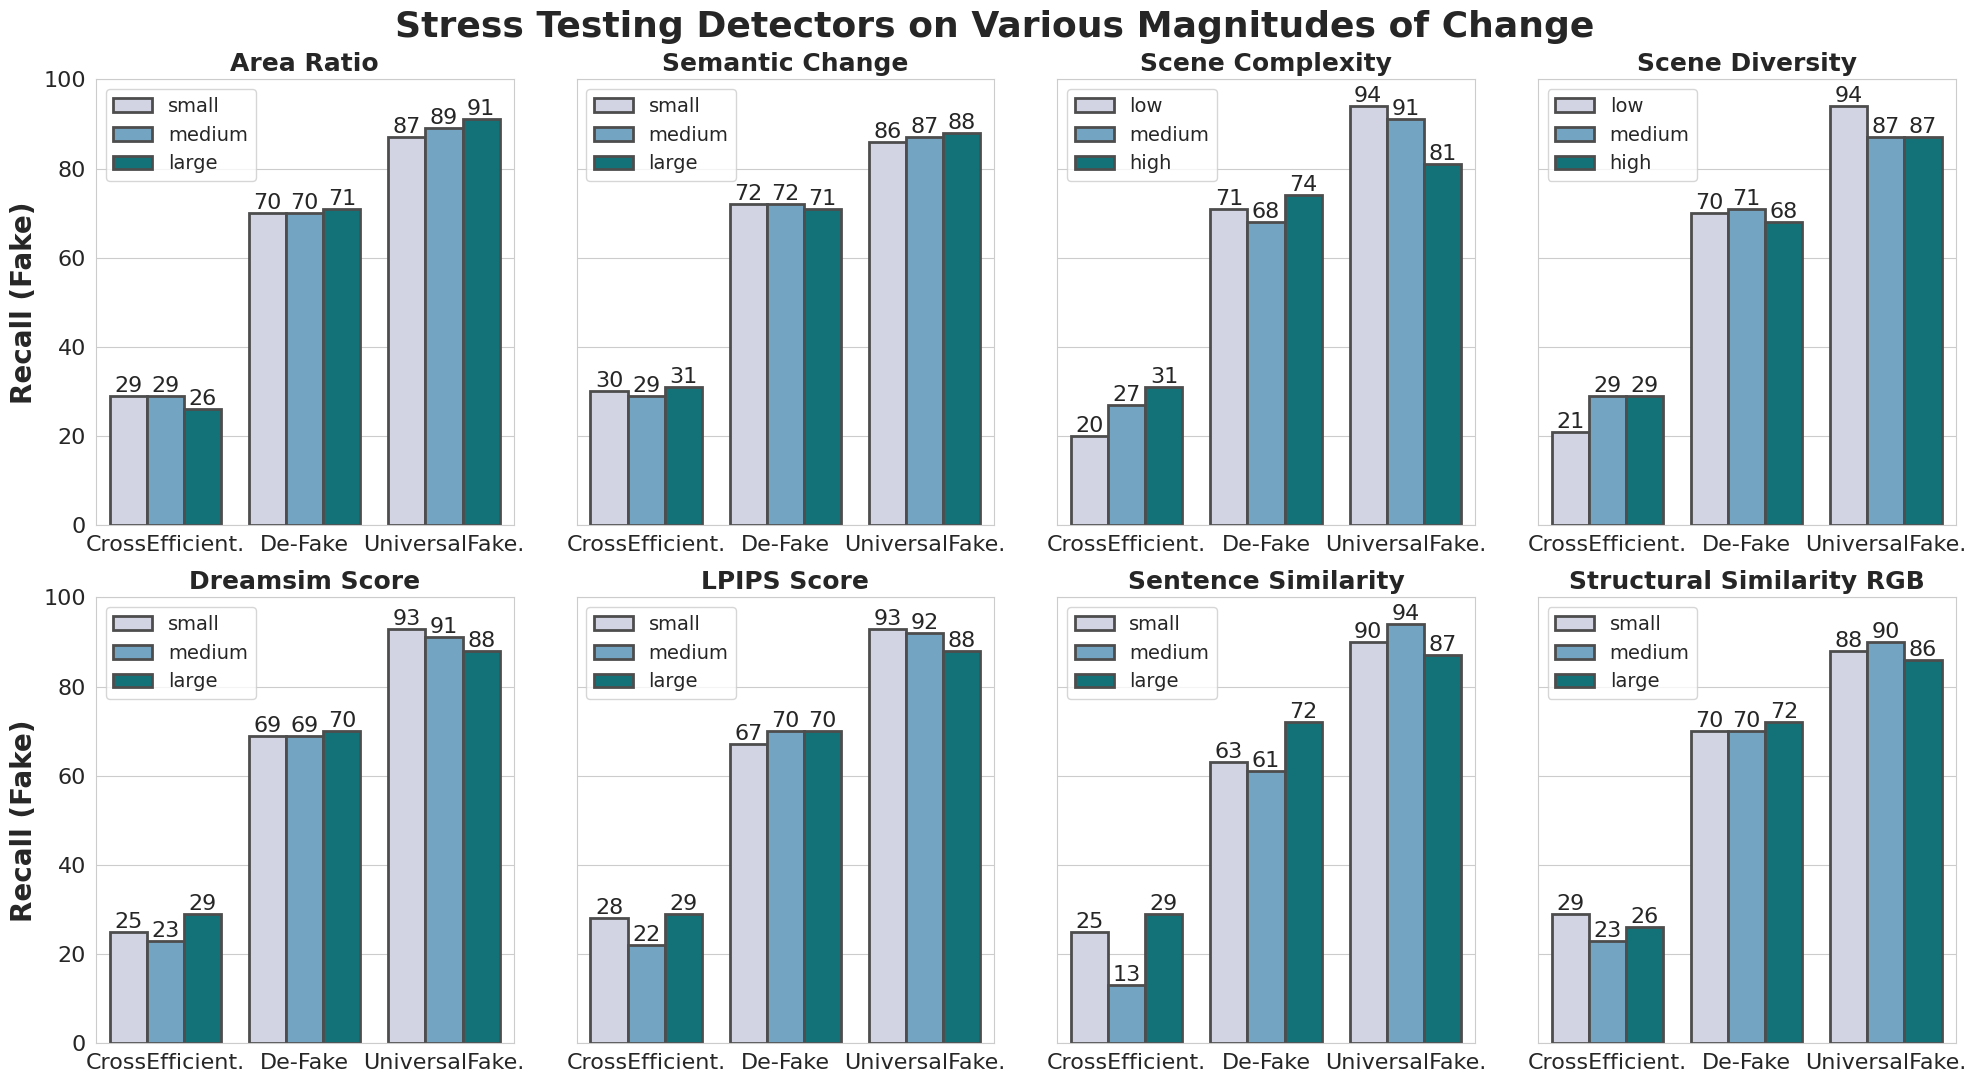

In [33]:
import seaborn as sns
sns.set_style("whitegrid")


fig_palette = 'PuBuGn' #RdYlBu #gist_earth #PuBuGn
title_size = 26
barlabel_size = 16
header_size = 18
legend_size = 14
ylabel_size = 20
xlabel_size = 16
xlabel_rot = 0
xtick_size = 16
fig_linewidth = 2
fig_edgecolor = '0.3'


fig, axes = plt.subplots(2, 4, sharey=True, figsize=(20,11))
fig.suptitle('Stress Testing Detectors on Various Magnitudes of Change', fontsize=title_size, fontweight='bold')


# ratio
ratio_metrics_sm = thin_bins(ratio_metrics, 'ratio_category')
ratio_metrics_sm['recall_fake'] = ratio_metrics_sm['recall_fake'].round(0)

sns.barplot(
    ax=axes[0,0],
    data=ratio_metrics_sm, 
    x="detector", 
    y="recall_fake", 
    hue="ratio_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
)
    
axes[0,0].set_title("Area Ratio", fontsize=header_size, fontweight='bold')
axes[0,0].legend(title=None, fontsize=legend_size)
axes[0,0].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[0,0].set(xlabel=None)
axes[0,0].tick_params(axis='y', labelsize=xtick_size)
axes[0,0].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[0,0].containers:
    axes[0,0].bar_label(i, fontsize=barlabel_size)
    
    
# semantic mag
sem_mag_metrics['recall_fake'] = sem_mag_metrics['recall_fake'].round(0)

sns.barplot(
    ax=axes[0,1],
    data=sem_mag_metrics, 
    x="detector", 
    y="recall_fake", 
    hue="sem_magnitude", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
)
    
axes[0,1].set_title("Semantic Change", fontsize=header_size, fontweight='bold')
axes[0,1].legend(title=None, fontsize=legend_size)
axes[0,1].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[0,1].set(xlabel=None)
axes[0,1].tick_params(axis='y', labelsize=xtick_size)
axes[0,1].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[0,1].containers:
    axes[0,1].bar_label(i, fontsize=barlabel_size)
    

# scene density
scene_density_metrics['recall_fake'] = scene_density_metrics['recall_fake'].round(0)
sns.barplot(
    ax=axes[0,2],
    data=scene_density_metrics, 
    x="detector", 
    y="recall_fake", 
    hue="scene_complexity_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
) 
    
axes[0,2].set_title("Scene Complexity", fontsize=header_size, fontweight='bold')
axes[0,2].legend(title=None, fontsize=legend_size)
axes[0,2].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[0,2].set(xlabel=None)
axes[0,2].tick_params(axis='y', labelsize=xtick_size)
axes[0,2].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[0,2].containers:
    axes[0,2].bar_label(i, fontsize=barlabel_size)
    
    
# scene diversity
scene_div_metrics['recall_fake'] = scene_div_metrics['recall_fake'].round(0)
sns.barplot(
    ax=axes[0,3],
    data=scene_div_metrics, 
    x="detector", 
    y="recall_fake", 
    hue="scene_diversity_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
) # Greens_d
    
axes[0,3].set_title("Scene Diversity", fontsize=header_size, fontweight='bold')
axes[0,3].legend(title=None, fontsize=legend_size)
axes[0,3].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[0,3].set(xlabel=None)
axes[0,3].tick_params(axis='y', labelsize=xtick_size)
axes[0,3].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[0,3].containers:
    axes[0,3].bar_label(i, fontsize=barlabel_size)
    

# dream_sim
dreamsim_metrics_sm = thin_bins(dreamsim_metrics, 'dreamsim_category')
dreamsim_metrics_sm['recall_fake'] = dreamsim_metrics_sm['recall_fake'].round(0)

sns.barplot(
    ax=axes[1,0],
    data=dreamsim_metrics_sm, 
    x="detector", 
    y="recall_fake", 
    hue="dreamsim_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
) 
    
axes[1,0].set_title("Dreamsim Score", fontsize=header_size, fontweight='bold')
axes[1,0].legend(title=None, fontsize=legend_size)
axes[1,0].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[1,0].set(xlabel=None)
axes[1,0].tick_params(axis='y', labelsize=xtick_size)
axes[1,0].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[1,0].containers:
    axes[1,0].bar_label(i, fontsize=barlabel_size)
    

# lpips_score
lpips_metrics_sm = thin_bins(lpips_metrics, 'lpips_score_category')
lpips_metrics_sm['recall_fake'] = lpips_metrics_sm['recall_fake'].round(0)

sns.barplot(
    ax=axes[1,1],
    data=lpips_metrics_sm, 
    x="detector", 
    y="recall_fake", 
    hue="lpips_score_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
) #
    
axes[1,1].set_title("LPIPS Score", fontsize=header_size, fontweight='bold')
axes[1,1].legend(title=None, fontsize=legend_size)
axes[1,1].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[1,1].set(xlabel=None)
axes[1,1].tick_params(axis='y', labelsize=xtick_size)
axes[1,1].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[1,1].containers:
    axes[1,1].bar_label(i, fontsize=barlabel_size)
    
    
# sentence sim
sen_sim_metrics_sm = thin_bins(sen_sim_metrics, 'sen_sim_category')
sen_sim_metrics_sm['recall_fake'] = sen_sim_metrics_sm['recall_fake'].round(0)

sns.barplot(
    ax=axes[1,2],
    data=sen_sim_metrics_sm, 
    x="detector", 
    y="recall_fake", 
    hue="sen_sim_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
) 
    
axes[1,2].set_title("Sentence Similarity", fontsize=header_size, fontweight='bold')
axes[1,2].legend(title=None, fontsize=legend_size)
axes[1,2].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[1,2].set(xlabel=None)
axes[1,2].tick_params(axis='y', labelsize=xtick_size)
axes[1,2].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[1,2].containers:
    axes[1,2].bar_label(i, fontsize=barlabel_size)
    
    
# structural similarity
ssim_rgb_metrics_sm = thin_bins(ssim_rgb_metrics, 'ssim_rgb_category')
ssim_rgb_metrics_sm['recall_fake'] = ssim_rgb_metrics_sm['recall_fake'].round(0)

sns.barplot(
    ax=axes[1,3],
    data=ssim_rgb_metrics_sm, 
    x="detector", 
    y="recall_fake", 
    hue="ssim_rgb_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
)
    
axes[1,3].set_title("Structural Similarity RGB", fontsize=header_size, fontweight='bold')
axes[1,3].legend(title=None, fontsize=legend_size)
axes[1,3].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[1,3].set(xlabel=None)
axes[1,3].tick_params(axis='y', labelsize=xtick_size)
axes[1,3].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)
axes[1,3].set_ylim((0,100))

for i in axes[1,3].containers:
    axes[1,3].bar_label(i, fontsize=barlabel_size)

plt.tight_layout()
plt.savefig("figures/change_metric_performance_cool_no_border.png")
plt.savefig("figures/change_metric_performance_cool_no_border.pdf")

plt.show()

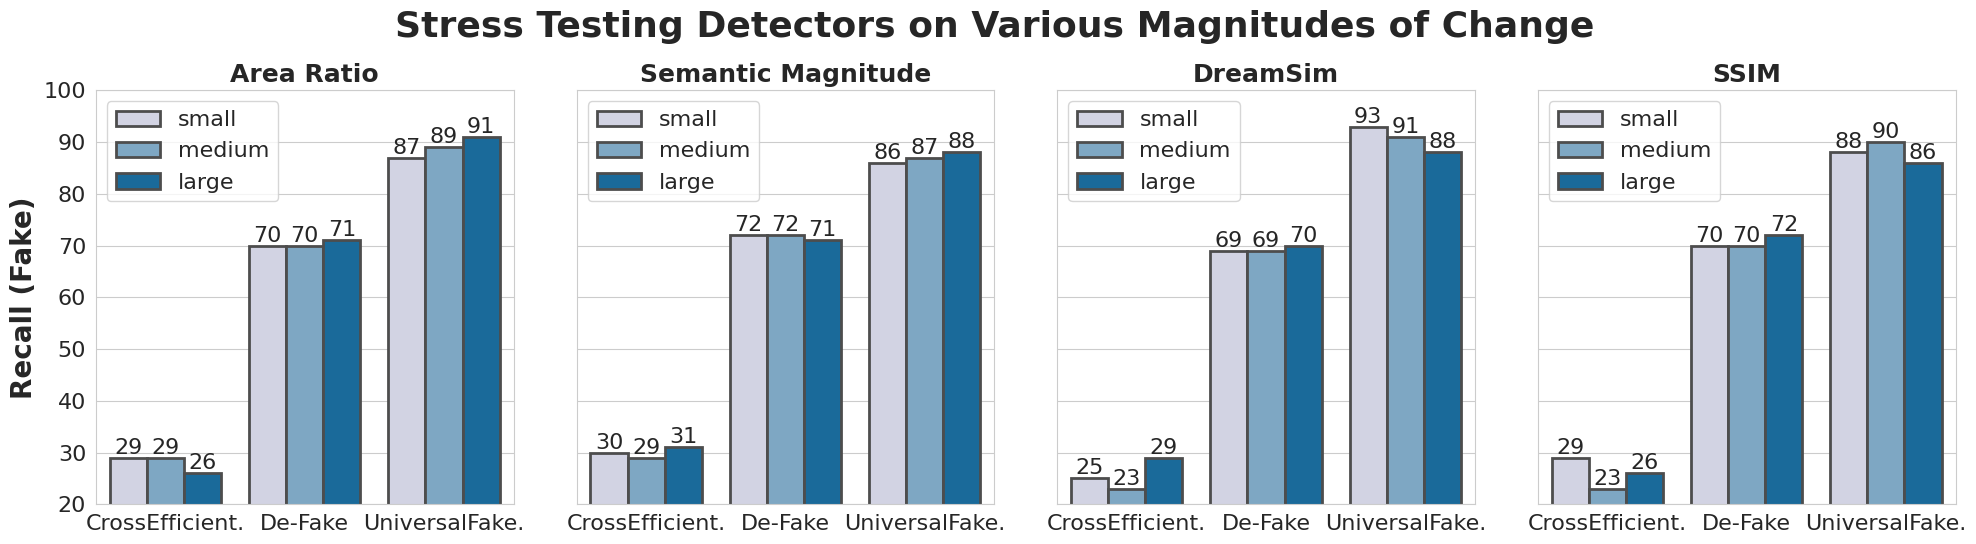

In [38]:
import seaborn as sns
sns.set_style("whitegrid")


fig_palette = 'PuBu' #RdYlBu #gist_earth #PuBuGn
title_size = 26
barlabel_size = 16
header_size = 18
legend_size = 16
ylabel_size = 20
xlabel_size = 16
xlabel_rot = 0
xtick_size = 16
fig_linewidth = 2
fig_edgecolor = '0.3'


fig, axes = plt.subplots(1, 4, sharey=True, figsize=(20,5.5))
fig.suptitle('Stress Testing Detectors on Various Magnitudes of Change', fontsize=title_size, fontweight='bold')


# ratio
ratio_metrics_sm = thin_bins(ratio_metrics, 'ratio_category')
ratio_metrics_sm['recall_fake'] = ratio_metrics_sm['recall_fake'].round(0)

sns.barplot(
    ax=axes[0],
    data=ratio_metrics_sm, 
    x="detector", 
    y="recall_fake", 
    hue="ratio_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
)
    
axes[0].set_title("Area Ratio", fontsize=header_size, fontweight='bold')
axes[0].legend(title=None, fontsize=legend_size)
axes[0].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[0].set(xlabel=None)
axes[0].tick_params(axis='y', labelsize=xtick_size)
axes[0].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[0].containers:
    axes[0].bar_label(i, fontsize=barlabel_size)
    
    
# semantic mag
sem_mag_metrics['recall_fake'] = sem_mag_metrics['recall_fake'].round(0)

sns.barplot(
    ax=axes[1],
    data=sem_mag_metrics, 
    x="detector", 
    y="recall_fake", 
    hue="sem_magnitude", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
)
    
axes[1].set_title("Semantic Magnitude", fontsize=header_size, fontweight='bold')
axes[1].legend(title=None, fontsize=legend_size)
axes[1].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[1].set(xlabel=None)
axes[1].tick_params(axis='y', labelsize=xtick_size)
axes[1].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[1].containers:
    axes[1].bar_label(i, fontsize=barlabel_size)
    

# dream_sim
dreamsim_metrics_sm = thin_bins(dreamsim_metrics, 'dreamsim_category')
dreamsim_metrics_sm['recall_fake'] = dreamsim_metrics_sm['recall_fake'].round(0)

sns.barplot(
    ax=axes[2],
    data=dreamsim_metrics_sm, 
    x="detector", 
    y="recall_fake", 
    hue="dreamsim_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
) 
    
axes[2].set_title("DreamSim", fontsize=header_size, fontweight='bold')
axes[2].legend(title=None, fontsize=legend_size)
axes[2].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[2].set(xlabel=None)
axes[2].tick_params(axis='y', labelsize=xtick_size)
axes[2].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)


for i in axes[2].containers:
    axes[2].bar_label(i, fontsize=barlabel_size)
    
    
# structural similarity
ssim_rgb_metrics_sm = thin_bins(ssim_rgb_metrics, 'ssim_rgb_category')
ssim_rgb_metrics_sm['recall_fake'] = ssim_rgb_metrics_sm['recall_fake'].round(0)

sns.barplot(
    ax=axes[3],
    data=ssim_rgb_metrics_sm, 
    x="detector", 
    y="recall_fake", 
    hue="ssim_rgb_category", 
    palette=fig_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
)
    
axes[3].set_title("SSIM", fontsize=header_size, fontweight='bold')
axes[3].legend(title=None, fontsize=legend_size)
axes[3].set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
axes[3].set(xlabel=None)
axes[3].tick_params(axis='y', labelsize=xtick_size)
axes[3].tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xlabel_size)
axes[3].set_ylim((20,100))

for i in axes[3].containers:
    axes[3].bar_label(i, fontsize=barlabel_size)

plt.tight_layout()
plt.savefig("figures/change_metric_performance_cool_no_border_sm.png")
plt.savefig("figures/change_metric_performance_cool_no_border_sm.pdf")

plt.show()

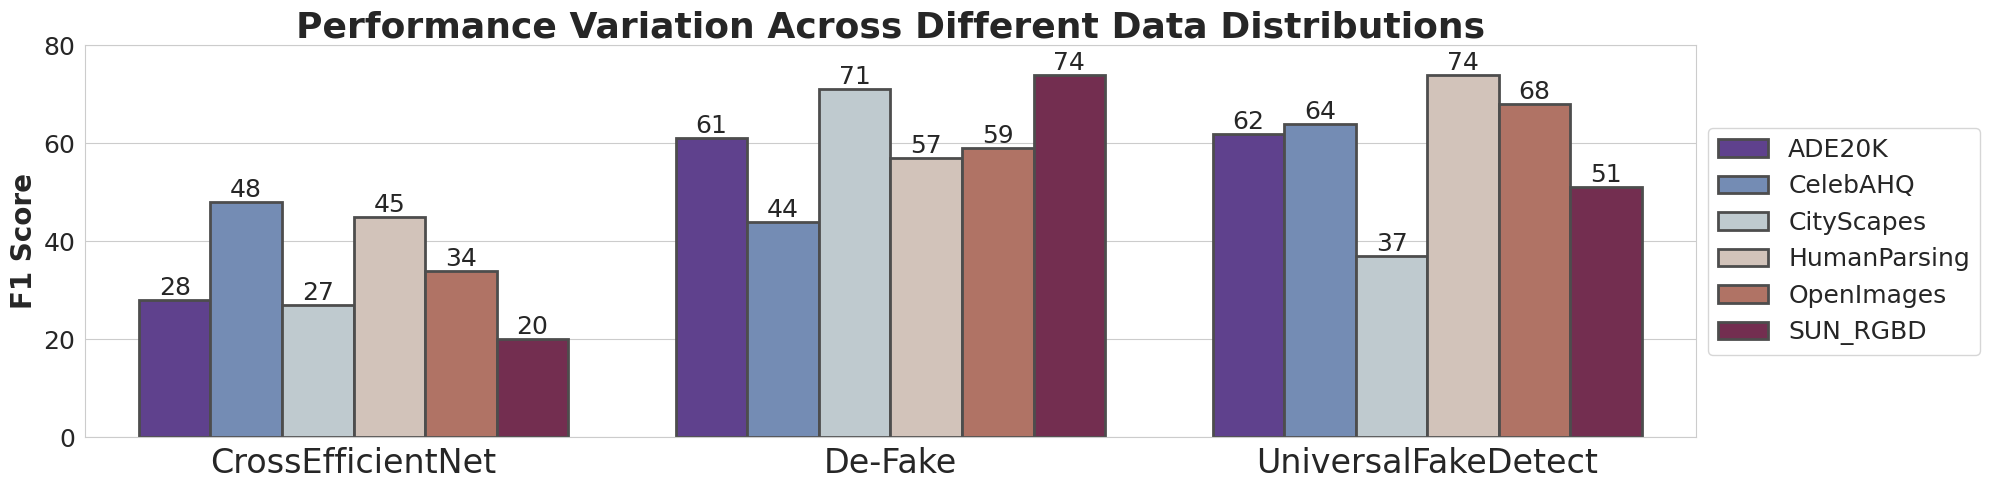

In [40]:
title_size = 26
barlabel_size = 18
legend_size = 18
ylabel_size = 20
xtick_size = 24
ytick_size = 18
fig_linewidth = 2
fig_edgecolor = '0.3'

fig, ax = plt.subplots(1, 1, figsize=(20,5))
dataset_metrics['f1'] = dataset_metrics['f1'].round(0)
dataset_metrics['detector'] = dataset_metrics.detector.replace(
    {
        'CrossEfficient.': 'CrossEfficientNet',
        'UniversalFake.': 'UniversalFakeDetect'
    }
)

sns.barplot(
    ax=ax,
    data=dataset_metrics, 
    x="detector", 
    y="f1", 
    hue="dataset",
    linewidth=fig_linewidth,
    edgecolor=fig_edgecolor,
    palette='twilight_shifted', #RdYlBu #gist_earth #PuBuGn
)

plt.ylabel("F1 Score", fontsize=ylabel_size, fontweight='bold')
ax.tick_params(axis='x', labelsize=xtick_size)
ax.tick_params(axis='y', labelsize=ytick_size)
ax.legend(title=None, fontsize=legend_size, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i, fontsize=barlabel_size)
        
plt.ylim((0,80))
plt.title("Performance Variation Across Different Data Distributions", fontsize=title_size, fontweight='bold')
plt.tight_layout()
plt.savefig("figures/benchmark_performance_purpl_noborder.png")
plt.savefig("figures/benchmark_performance_purpl_noborder.pdf")

plt.show()

In [44]:
model_metrics['recall_fake'] = model_metrics['recall_fake'].map(lambda x: x * 100)
method_metrics['recall_fake'] = method_metrics['recall_fake'].map(lambda x: x * 100)



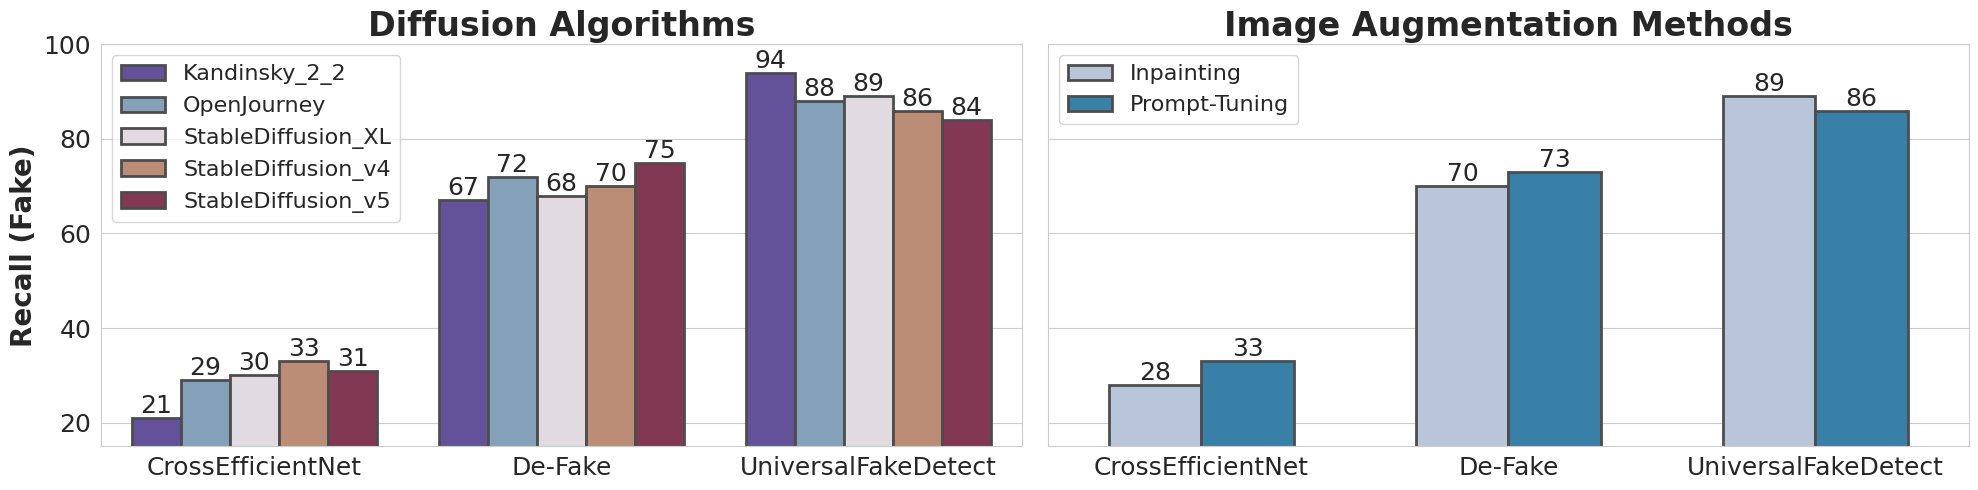

In [45]:

import matplotlib.gridspec as gridspec

title_size = 24
barlabel_size = 18
legend_size = 16
ylabel_size = 20
xtick_size = 18
ytick_size = 18
fig_linewidth = 2
fig_edgecolor = '0.3'

# fig = plt.figure(figsize=(20,5))
# gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,5), sharey=True)


# ax0 = plt.subplot(gs[0, :2])
model_metrics['recall_fake'] = model_metrics['recall_fake'].round(0)
model_metrics['detector'] = model_metrics.detector.replace(
    {
        'CrossEfficient.': 'CrossEfficientNet',
        'UniversalFake.': 'UniversalFakeDetect'
    },
)

sns.barplot(
    ax=ax0,
    data=model_metrics, 
    x="detector", 
    y="recall_fake", 
    hue="model",
    linewidth=fig_linewidth,
    edgecolor=fig_edgecolor,
    palette='twilight_shifted', #RdYlBu #gist_earth #PuBuGn
)

ax0.set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
ax0.tick_params(axis='x', labelsize=xtick_size)
ax0.tick_params(axis='y', labelsize=ytick_size)
ax0.legend(
    title=None, 
    fontsize=legend_size, 
    # loc='center left', 
    # bbox_to_anchor=(1, 0.5)
)
ax0.set_title("Diffusion Algorithms", fontsize=title_size, fontweight='bold')
ax0.set(xlabel=None)
for i in ax0.containers:
    ax0.bar_label(i, fontsize=barlabel_size)


#  ax1 = plt.subplot(gs[0, 2])
method_metrics['recall_fake'] = method_metrics['recall_fake'].round(0)
method_metrics['detector'] = method_metrics.detector.replace(
    {
        'CrossEfficient.': 'CrossEfficientNet',
        'UniversalFake.': 'UniversalFakeDetect'
    }
)
method_metrics['method'] = method_metrics.method.replace(
    {
        'inpainting': 'Inpainting',
        'p2p': 'Prompt-Tuning'
    }
)

sns.barplot(
    ax=ax1,
    data=method_metrics, 
    x="detector", 
    y="recall_fake", 
    hue="method",
    width = 0.6,
    linewidth=fig_linewidth,
    edgecolor=fig_edgecolor,
    palette='PuBu', #RdYlBu #gist_earth #PuBuGn
)

ax0.set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
ax1.tick_params(axis='x', labelsize=xtick_size)
ax1.tick_params(axis='y', labelsize=ytick_size)
ax1.legend(
    title=None, 
    fontsize=legend_size, 
    # loc='center left', 
    # bbox_to_anchor=(1, 0.5)
)
ax1.set_title("Image Augmentation Methods", fontsize=title_size, fontweight='bold')


ax1.set(xlabel=None)
for i in ax1.containers:
    ax1.bar_label(i, fontsize=barlabel_size)

        
plt.ylim((15,100))
plt.tight_layout()
plt.savefig("figures/method_model_performance.png")
plt.savefig("figures/method_model_performance.pdf")

plt.show()

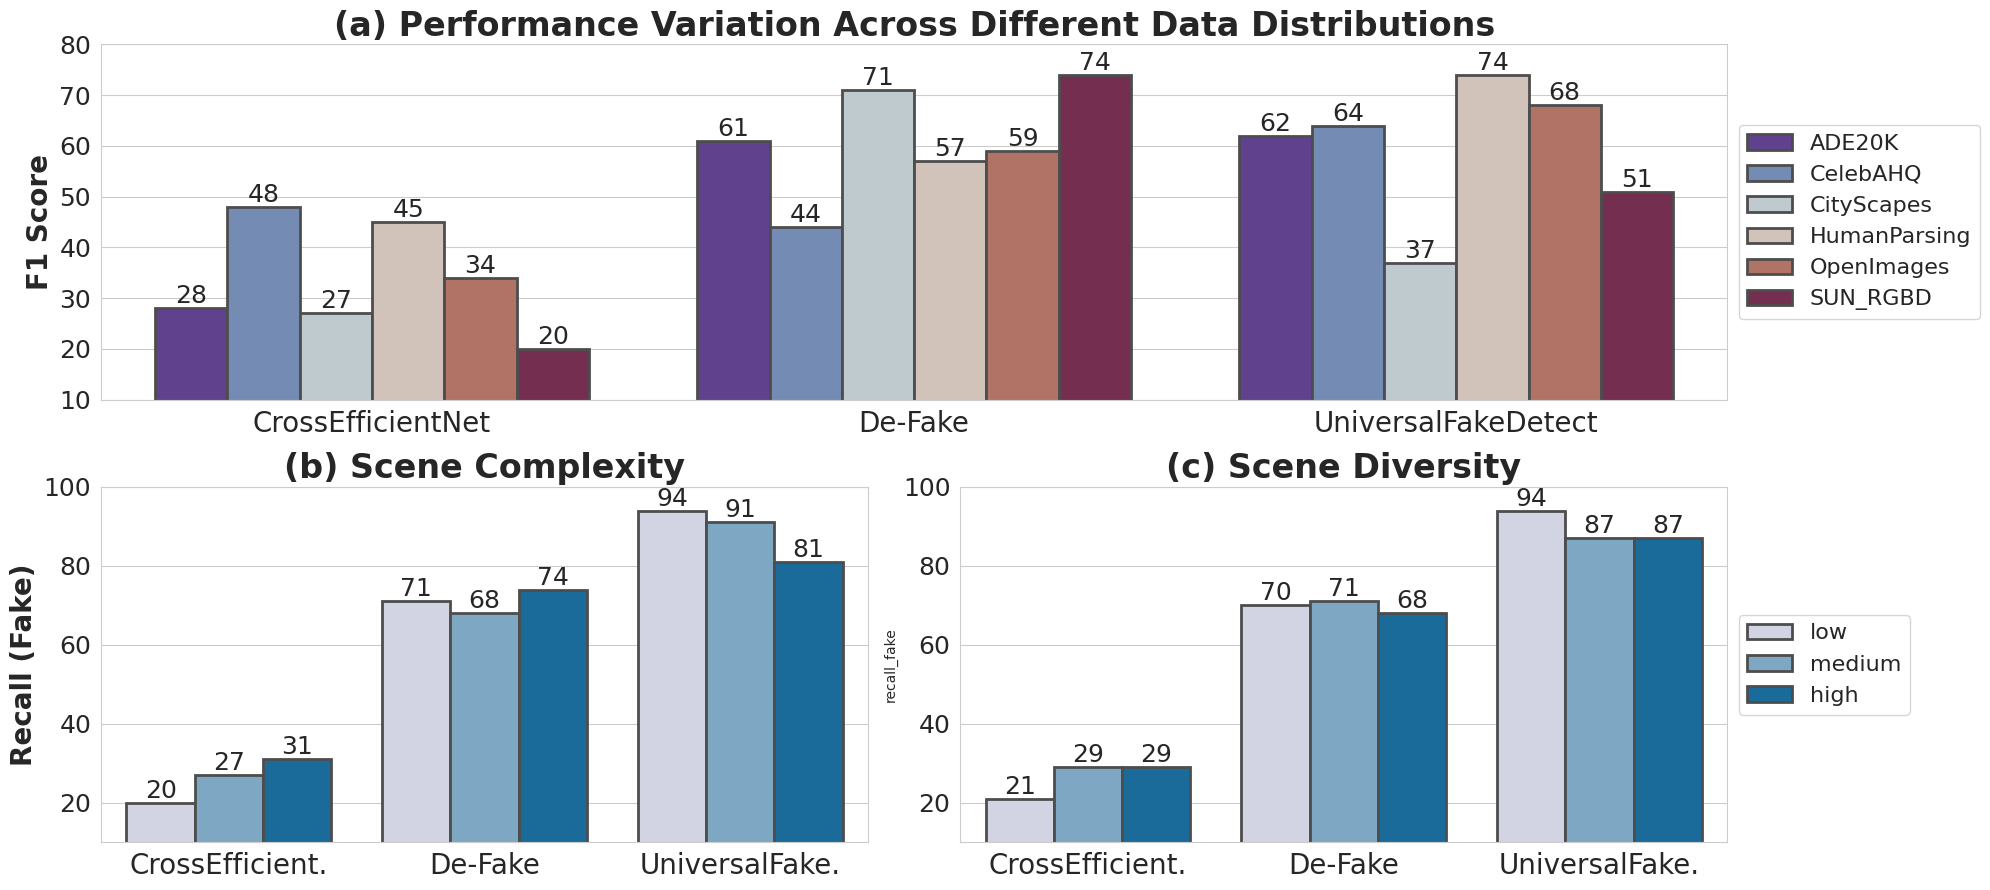

In [50]:
"""
title_size = 24
barlabel_size = 18
legend_size = 16
ylabel_size = 20
xtick_size = 18
ytick_size = 18
"""


title_size = 24
barlabel_size = 18
legend_size = 16
ylabel_size = 20
xtick_size = 20
ytick_size = 18
fig_linewidth = 2
fig_edgecolor = '0.3'
subplt_palette =  'PuBu'

fig = plt.figure(figsize=(20,9))
dataset_metrics['f1'] = dataset_metrics['f1'].round(0)
dataset_metrics['detector'] = dataset_metrics.detector.replace(
    {
        'CrossEfficient.': 'CrossEfficientNet',
        'UniversalFake.': 'UniversalFakeDetect'
    }
)

# performance across benchmarks
ax0 = plt.subplot(2, 1, 1)
sns.barplot(
    ax=ax0,
    data=dataset_metrics, 
    x="detector", 
    y="f1", 
    hue="dataset",
    linewidth=fig_linewidth,
    edgecolor=fig_edgecolor,
    palette='twilight_shifted', #RdYlBu #gist_earth #PuBuGn
)

ax0.set_ylabel("F1 Score", fontsize=ylabel_size, fontweight='bold')
ax0.tick_params(axis='x', labelsize=xtick_size)
ax0.tick_params(axis='y', labelsize=ytick_size)
ax0.legend(title=None, fontsize=legend_size, loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title("(a) Performance Variation Across Different Data Distributions", fontsize=title_size, fontweight='bold')
ax0.set_ylim((10,80))

ax0.set(xlabel=None)
for i in ax0.containers:
    ax0.bar_label(i, fontsize=barlabel_size)
    
    
# scene complexity
ax1 =  plt.subplot(2, 2, 3)
scene_density_metrics['recall_fake'] = scene_density_metrics['recall_fake'].round(0)
sns.barplot(
    ax=ax1,
    data=scene_density_metrics, 
    x="detector", 
    y="recall_fake", 
    hue="scene_complexity_category", 
    palette=subplt_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
) 
    
ax1.set_title("(b) Scene Complexity", fontsize=title_size, fontweight='bold')
# ax1.legend(title=None, fontsize=legend_size)
ax1.legend_.remove()
ax1.set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
ax1.set(xlabel=None)
ax1.tick_params(axis='y', labelsize=ytick_size)
ax1.tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xtick_size)
for i in ax1.containers:
    ax1.bar_label(i, fontsize=barlabel_size)
ax1.set_ylim((10,100))

ax2 = plt.subplot(2, 2, 4)
scene_div_metrics['recall_fake'] = scene_div_metrics['recall_fake'].round(0)
sns.barplot(
    ax=ax2,
    data=scene_div_metrics, 
    x="detector", 
    y="recall_fake", 
    hue="scene_diversity_category", 
    palette=subplt_palette,
    linewidth=fig_linewidth,
    edgecolor='0.3',
) # Greens_d
    
ax2.set_title("(c) Scene Diversity", fontsize=title_size, fontweight='bold')
ax2.legend(title=None, fontsize=legend_size, loc='center left', bbox_to_anchor=(1, 0.5))
# ax2.set_ylabel("Recall (Fake)", fontsize=ylabel_size, fontweight='bold')
ax2.set(xlabel=None)
ax2.tick_params(axis='y', labelsize=ytick_size)
ax2.tick_params(axis='x', labelrotation=xlabel_rot, labelsize=xtick_size)
ax2.set_ylim((10,100))

for i in ax2.containers:
    ax2.bar_label(i, fontsize=barlabel_size)

plt.tight_layout()
plt.savefig("figures/benchmark_performance_v2.png")
plt.savefig("figures/benchmark_performance_v2.pdf")
plt.show()

In [84]:
!pwd

/home/jkruk3/how_fake/stress_testing


# Change on Semantic Change Pairs

In [191]:
import re

exp = model_preds[list(model_preds.keys())[0]]
exp = exp.dropna(subset=['perturbed_mask_name', 'mask_name'])

exp['perturbed_mask_name'] = exp['perturbed_mask_name'].str.lower()
exp['perturbed_mask_name'] = exp['perturbed_mask_name'].replace('_', " ", regex=True)
exp['perturbed_mask_name'] = exp['perturbed_mask_name'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
exp['perturbed_mask_name'] = exp['perturbed_mask_name'].apply(lambda x: x.strip())

exp['mask_name'] = exp['mask_name'].str.lower()
exp['mask_name'] = exp['mask_name'].replace('_', " ", regex=True)
exp['mask_name'] = exp['mask_name'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
exp['mask_name'] = exp['mask_name'].apply(lambda x: x.strip())

In [195]:
sem_pairs = exp[['mask_name', 'perturbed_mask_name']].value_counts().reset_index(name='counts')
sem_pairs = sem_pairs.loc[sem_pairs.counts>10]

In [196]:
sem_pairs

,mask_name,perturbed_mask_name,counts
0,hair,wig,412
1,wall,wall with added texture,255
2,hair,hair with more volume,242
3,vegetation,tree,225
4,wall,wallpaper,220
...,...,...,...
330,road,car,11
331,dress,the dress with a sheer overlay,11
332,cloth,silk scarf,11
333,grass,trees,11


In [263]:
def compute_metrics_sem_pairs(data_sample):
    """
    This function will compute all relevant metrics for 
    full set of predictions. This includes the following:
    
        accuracy, precision, recall, f1, 
        precision-1, recall-1, f1-1,
        precision-0, recall-0, f1-0
        
    Metrics are returns in a pd.DataFrame.
    """
    
    if 'real' in list(data_sample.label):
        data_sample["label"] = data_sample.label.map(lambda x: 1 if x == 'fake' else 0)
    data_sample = data_sample.dropna(subset='prediction')
    
    y_true = list(data_sample.label.astype(int))
    y_pred = list(data_sample.prediction.astype(int))

    accuracy = accuracy_score(y_true, y_pred)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, beta=1.0, average='macro')
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, beta=1.0)

    metrics_df = pd.DataFrame()
    metrics_df['accuracy'] = [accuracy]
    
    if len(precision) == 0:
        metrics_df['precision_fake'] = [pd.NA]
        metrics_df['recall_fake'] = [pd.NA]
        metrics_df['f1_fake'] = [pd.NA]
    else:
        try:
            metrics_df['precision_fake'] = [float(precision[1])]
            metrics_df['recall_fake'] = [float(recall[1])]
            metrics_df['f1_fake'] = [float(f1[1])]
        except IndexError:
            if type(precision) == list:
                metrics_df['precision_fake'] = [float(precision[0])]
                metrics_df['recall_fake'] = [float(recall[0])]
                metrics_df['f1_fake'] = [float(f1[0])]
            else:
                metrics_df['precision_fake'] = [float(precision)]
                metrics_df['recall_fake'] = [float(recall)]
                metrics_df['f1_fake'] = [float(f1)]
            
    return metrics_df

In [264]:
def normalize_sem_labels(exp):
    exp = exp.dropna(subset=['perturbed_mask_name', 'mask_name'])
    exp['perturbed_mask_name'] = exp['perturbed_mask_name'].str.lower()
    exp['perturbed_mask_name'] = exp['perturbed_mask_name'].replace('_', " ", regex=True)
    exp['perturbed_mask_name'] = exp['perturbed_mask_name'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    exp['perturbed_mask_name'] = exp['perturbed_mask_name'].apply(lambda x: x.strip())

    exp['mask_name'] = exp['mask_name'].str.lower()
    exp['mask_name'] = exp['mask_name'].replace('_', " ", regex=True)
    exp['mask_name'] = exp['mask_name'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    exp['mask_name'] = exp['mask_name'].apply(lambda x: x.strip())
    return exp


evals = {}

for m, df in model_preds.items():
    if m in accept_models:
        print(m)
        sem_m = sem_pairs.copy()
        sem_m['model'] = [pd.NA]* len(sem_m)
        sem_m['recall_fake'] = [pd.NA]* len(sem_m)
        sem_m['f1_fake'] = [pd.NA]* len(sem_m)
    
        df_ = df.copy()
        df_ = normalize_sem_labels(df_)
        
        for i, row in tqdm(sem_m.iterrows(), total=len(sem_m)):
            samp_ = df_.loc[
                (df_.perturbed_mask_name==row.perturbed_mask_name) 
                & (df_.mask_name==row.mask_name)
            ]
            metrics = compute_metrics_sem_pairs(samp_)
            sem_m.at[i, 'model'] = m
            sem_m.at[i, 'recall_fake'] = metrics.recall_fake.values
            sem_m.at[i, 'f1_fake'] = metrics.f1_fake.values
            
        sem_m = sem_m.dropna(subset='recall_fake')
        sem_m['recall_fake'] = sem_m['recall_fake'].apply(lambda x: x * 100)
        sem_m['f1_fake'] = sem_m['f1_fake'].apply(lambda x: x * 100)
        
        try:
            sem_m = sem_m.dropna(subset='recall_fake')
            sem_m['recall_fake'] = sem_m['recall_fake'].astype(float).round(2)
            sem_m['f1_fake'] = sem_m['f1_fake'].astype(float).round(2)
        except:
            pdb.set_trace()
        
        sem_m = sem_m.loc[sem_m.recall_fake > 0]
        evals[m] = sem_m
    

UniversalFakeDetect


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:04<00:00, 76.46it/s]


CrossEfficientNet


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:04<00:00, 76.97it/s]


De-Fake


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:04<00:00, 76.54it/s]


## UniversalFakeDetect

In [265]:
ufd = evals['UniversalFakeDetect'].loc[evals['UniversalFakeDetect'].counts>=50]
ufd = ufd.sort_values(by=['recall_fake', 'counts'], ascending=False)

In [266]:
ufd.head(10)

,mask_name,perturbed_mask_name,counts,model,recall_fake,f1_fake
36,skin,leather,74,UniversalFakeDetect,98.65,99.32
24,right ear,earring,117,UniversalFakeDetect,97.44,98.70
7,skin,fur,182,UniversalFakeDetect,97.25,98.61
18,nose,nose ring,138,UniversalFakeDetect,97.10,98.53
8,left ear,earring,177,UniversalFakeDetect,96.61,98.28
51,right ear,right ear with a slight shadow,57,UniversalFakeDetect,96.49,98.21
5,lower lip,lipstick,190,UniversalFakeDetect,96.32,98.12
30,right brow,right brow with a slight arch,90,UniversalFakeDetect,95.56,97.73
42,left ear,left ear with a slight shadow,64,UniversalFakeDetect,95.31,97.60
19,nose,nose with a third eye,131,UniversalFakeDetect,94.66,97.25


In [267]:
ufd.tail(10)

,mask_name,perturbed_mask_name,counts,model,recall_fake,f1_fake
47,vegetation,car,58,UniversalFakeDetect,70.69,82.83
23,car,mercedesbenz,118,UniversalFakeDetect,70.34,82.59
49,building,building with more windows,57,UniversalFakeDetect,68.42,81.25
9,vegetation,vegetation with no leaves,175,UniversalFakeDetect,66.86,80.14
3,vegetation,tree,225,UniversalFakeDetect,66.67,80.00
55,sky,building,50,UniversalFakeDetect,66.00,79.52
12,ego vehicle,mercedesbenz,161,UniversalFakeDetect,65.84,79.40
15,vegetation,building,150,UniversalFakeDetect,65.33,79.03
16,out of roi,car,147,UniversalFakeDetect,58.50,73.82
53,out of roi,out of roi with blurred background,50,UniversalFakeDetect,56.00,71.79


In [269]:
ufd_exps = pd.concat([ufd.head(10), ufd.tail(10)])
ufd_exps.to_csv('eval/universalfakedetect_eval_sem_pairs.csv', index=False)

## De-Fake

In [270]:
dfake = evals['De-Fake'].loc[evals['De-Fake'].counts>=50]
dfake = dfake.sort_values(by=['recall_fake', 'counts'], ascending=False)

In [271]:
dfake.head(10)

,mask_name,perturbed_mask_name,counts,model,recall_fake,f1_fake
53,out of roi,out of roi with blurred background,50,De-Fake,88.00,93.62
50,car,car with shiny silver paint,57,De-Fake,85.96,92.45
3,vegetation,tree,225,De-Fake,84.89,91.83
49,building,building with more windows,57,De-Fake,84.21,91.43
44,building,bridge,60,De-Fake,83.33,90.91
41,building,building with a vibrant futuristic color scheme,64,De-Fake,82.81,90.60
13,vegetation,trees,155,De-Fake,81.94,90.07
22,sidewalk,pavement,121,De-Fake,81.82,90.00
12,ego vehicle,mercedesbenz,161,De-Fake,81.37,89.73
15,vegetation,building,150,De-Fake,80.67,89.30


In [272]:
dfake.tail(10)

,mask_name,perturbed_mask_name,counts,model,recall_fake,f1_fake
48,mouth,lips,58,De-Fake,63.79,77.89
20,skin,skin with subtle freckles,127,De-Fake,62.99,77.29
11,neck,necklace,162,De-Fake,62.96,77.27
30,right brow,right brow with a slight arch,90,De-Fake,62.22,76.71
51,right ear,right ear with a slight shadow,57,De-Fake,61.40,76.09
27,lower lip,lower lip with a slight blush,98,De-Fake,60.20,75.16
17,cloth,cloth with a subtle pattern,145,De-Fake,60.00,75.00
18,nose,nose ring,138,De-Fake,59.42,74.55
38,lower lip,nose,70,De-Fake,58.57,73.87
36,skin,leather,74,De-Fake,58.11,73.50


In [273]:
dfake_exps = pd.concat([dfake.head(10), dfake.tail(10)])
dfake_exps.to_csv('eval/defake_eval_sem_pairs.csv', index=False)

## CrossEfficientNet

In [274]:
cfn = evals['CrossEfficientNet'].loc[evals['CrossEfficientNet'].counts>=50]
cfn = cfn.sort_values(by=['recall_fake'], ascending=False)

In [275]:
cfn.head(10)

,mask_name,perturbed_mask_name,counts,model,recall_fake,f1_fake
38,lower lip,nose,70,CrossEfficientNet,66.67,80.00
54,table,desk,50,CrossEfficientNet,60.00,75.00
26,left brow,left brow with a slight arch,99,CrossEfficientNet,50.00,66.67
45,car,car with shiny chrome accents,59,CrossEfficientNet,45.16,62.22
23,car,mercedesbenz,118,CrossEfficientNet,42.65,59.79
47,vegetation,car,58,CrossEfficientNet,42.11,59.26
21,car,car with tinted windows,126,CrossEfficientNet,41.79,58.95
25,bag,handbag,108,CrossEfficientNet,41.67,58.82
35,car,truck,75,CrossEfficientNet,41.18,58.33
55,sky,building,50,CrossEfficientNet,39.29,56.41


In [276]:
cfn.tail(10)

,mask_name,perturbed_mask_name,counts,model,recall_fake,f1_fake
11,neck,necklace,162,CrossEfficientNet,17.65,30.00
7,skin,fur,182,CrossEfficientNet,17.39,29.63
4,wall,wallpaper,220,CrossEfficientNet,16.67,28.57
51,right ear,right ear with a slight shadow,57,CrossEfficientNet,16.67,28.57
5,lower lip,lipstick,190,CrossEfficientNet,15.79,27.27
17,cloth,cloth with a subtle pattern,145,CrossEfficientNet,15.38,26.67
24,right ear,earring,117,CrossEfficientNet,15.38,26.67
34,neck,necktie,82,CrossEfficientNet,11.11,20.00
20,skin,skin with subtle freckles,127,CrossEfficientNet,7.14,13.33
8,left ear,earring,177,CrossEfficientNet,6.67,12.50


In [277]:
cfn_exps = pd.concat([cfn.head(10), cfn.tail(10)])
cfn_exps.to_csv('eval/crossefficient_eval_sem_pairs.csv', index=False)